# Workspace \#7: ``model.py``

In [1]:
# %load firstcell.py
# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# getting future division
from __future__ import division

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

In [2]:
from random import random

import sys
sys.path.insert(0, '../')

import constants as ct
import particle as pt
import astro as ap
import echo as ec
import routines as rt
import data as dt
import model as md

/home/chen/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
# The contents of model.py
dir(md)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'ap',
 'ct',
 'ec',
 'np',
 'pt',
 'rt',
 'snr_routine']

In [4]:
# defining a test SNR
test_snr = dt.SuperNovaRemnant()
test_snr.__dict__ = {
    'Lpk': 10**(25.5+1.6*2),
    'age': 1.e4,
    'alpha': 0.5,
    'ang_size': None,
    'b': 0.,
    'distance': 0.1,
    'is_complete': False,
    'is_flux_certain': False,
    'is_spectral_certain': False,
    'is_type_certain': True,
    #'l': 178.,
    'l': 2.,
    'name': 'test',
    'no_dist': False,
    'no_flux': False,
 #'snu_at_1GHz': 160.0,
 #'snu_at_1GHz': 50,
    'sr': 1e-05,
    'tpk': 10**1.7,
    'type': 'S'}

/home/chen/Code/axion_laser/github/workspace_notebooks/../astro.py:887: RuntimeWarning: divide by zero encountered in true_divide
  sqrt(Omega_obs/Omega_res)
/home/chen/Code/axion_laser/github/workspace_notebooks/../echo.py:1142: RuntimeWarning: divide by zero encountered in true_divide
  return ga_ref * sqrt(sn_val/sn_ref)
/home/chen/Code/axion_laser/github/workspace_notebooks/../astro.py:887: RuntimeWarning: divide by zero encountered in true_divide
  sqrt(Omega_obs/Omega_res)
/home/chen/Code/axion_laser/github/workspace_notebooks/../echo.py:1142: RuntimeWarning: divide by zero encountered in true_divide
  return ga_ref * sqrt(sn_val/sn_ref)
/home/chen/Code/axion_laser/github/workspace_notebooks/../astro.py:887: RuntimeWarning: divide by zero encountered in true_divide
  sqrt(Omega_obs/Omega_res)
/home/chen/Code/axion_laser/github/workspace_notebooks/../echo.py:1142: RuntimeWarning: divide by zero encountered in true_divide
  return ga_ref * sqrt(sn_val/sn_ref)
/home/chen/Code/axion_

ga_arr: [2.70530312e-10 2.49496937e-10 2.49941073e-10 2.91072930e-10
 3.97602364e-10 5.98013097e-10 9.35432261e-10 1.48272906e-09
 2.36003684e-09            inf]


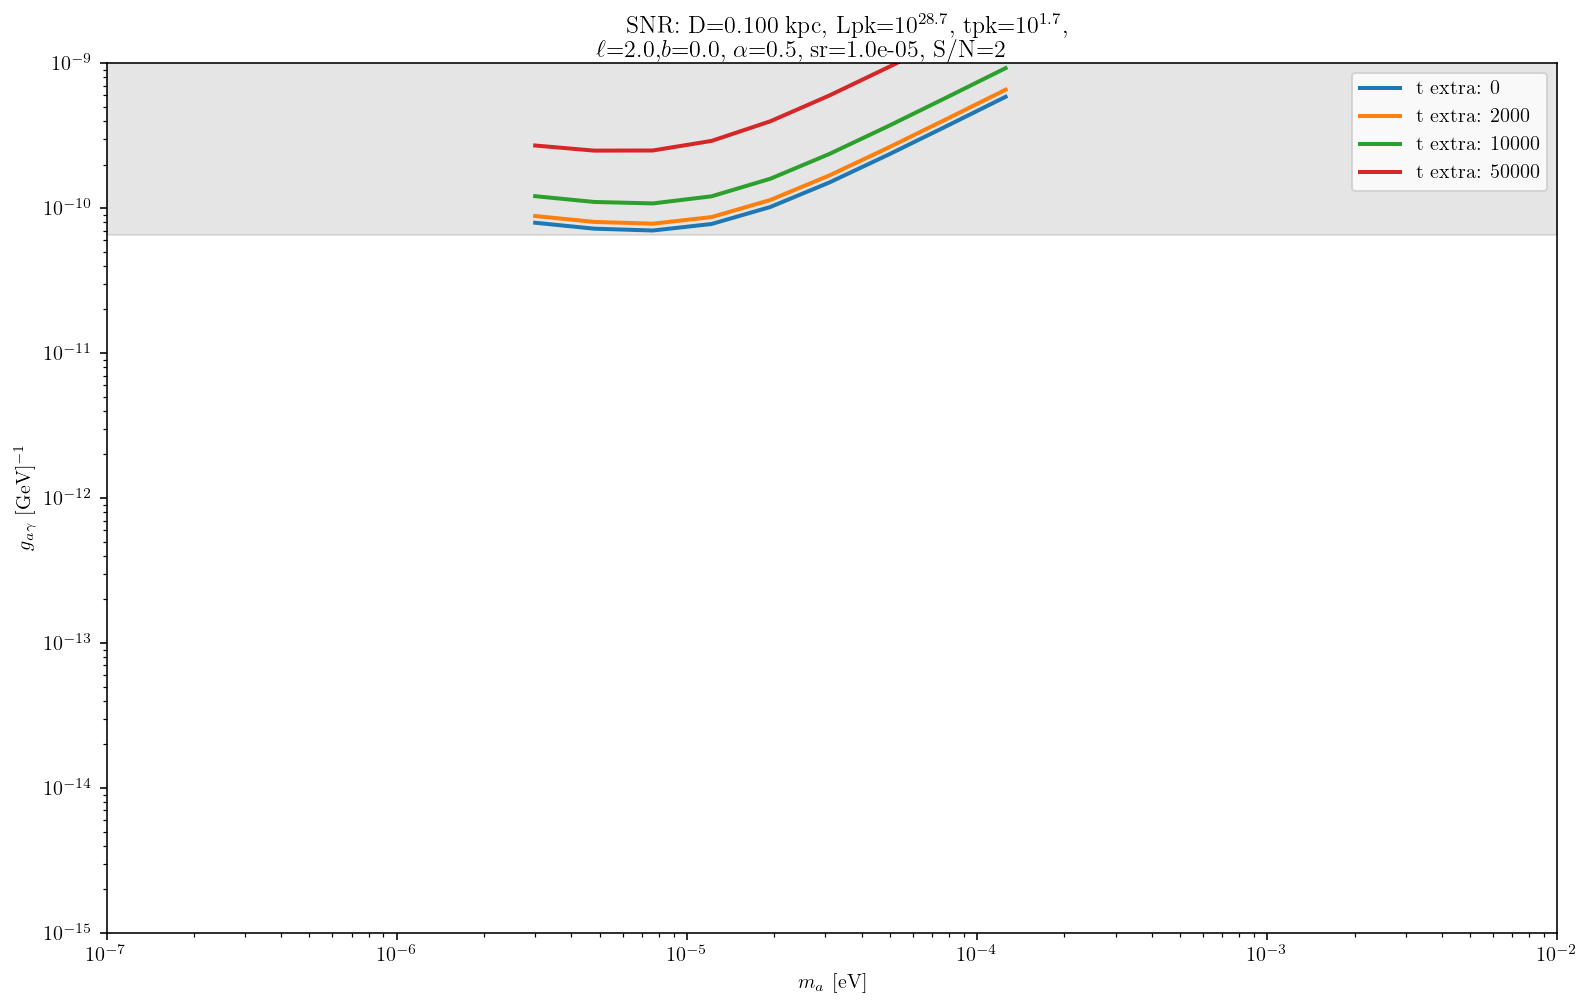

In [6]:
# t_extra_old = 5.e4
t_extra_arr = [0., 2000., 1.e4, 5.e4]
t_age = None #set in snr.__dict__
t_trans_over_t_peak = 30.
ma_arr = np.logspace(np.log10(3e-6), np.log10(2e-4), 10)
sig_noi_thres = 2.
ga_ref = 1.e-10 # doesn't matter, will be rescaled

counter = 0
best_snr = None
best_ga = 1.# at first ma point

plt.subplots()
#for _, snr in tqdm(snrs_dct.items(), total=len(snrs_dct.keys())):

for idx, t_extra_old in enumerate(t_extra_arr):
    color = 'C'+str(idx)
    for snr in [test_snr]:
        
        try:
            distance = snr.get_distance()

        except:
            continue
        
        L_peak = snr.Lpk
        t_peak = snr.tpk
        
        tage = snr.age
        snu_echo_kwargs = {'tmin_default':None,
                           'Nt':int(30*tage + 1), # for a fine enough array
                           'xmin':ct._au_over_kpc_,
                           'xmax_default':100.,
                           'use_quad':False,
                           'lin_space':False,
                           'Nint':int(30*tage + 1), # for a fine enough array
                           't_extra_old':t_extra_old
                          }
        # data:
        data = {'deltaE_over_E':1.e-3,
                'f_Delta':0.721,
                'exp':'SKA',
                'total_observing_time':100.,
                'verbose':0, 
                'average':True
               }
        
        t_trans=t_trans_over_t_peak*(t_peak/365)
        
        lightcurve_params = {'t_peak':t_peak,
                             'L_peak':L_peak,
                             't_age':tage,
                             't_trans':t_trans
                            }
        
        sig_noi = md.snr_routine(ma_arr, ga_ref,
                                 snr,
                                 lightcurve_params=lightcurve_params,
                                 snu_echo_kwargs=snu_echo_kwargs,
                                 data=data,
                                 output_all=False)
        
        ga_arr = ec.ga_reach(sig_noi_thres, sig_noi, ga_ref)
        
        plt.plot(ma_arr, ga_arr, lw='2.', color=color, alpha=1., label='t extra: %d' %t_extra_old)
        counter += 1

        if best_ga > ga_arr[0]:
            best_snr = snr
            best_ga = ga_arr[0]
    #     if counter == 2:
    #         break

ga_cast = 6.5e-11
plt.fill_between([1e-7, 1e-2], ga_cast, 1, color='grey', alpha=0.2)

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-15, 1e-9)
plt.xlim(1e-7, 1e-2)
plt.xlabel('$m_a$ [eV]')
plt.ylabel('$g_{a\gamma}$ [GeV]$^{-1}$')
plt.legend(loc='best')


title_str = r"SNR: D={D:.3f} kpc, Lpk=10$^{{{log10Lpk:.1f}}}$, tpk=10$^{{{log10tpk:.1f}}}$,\\$\ell$={ell:.1f},$b$={b:.1f}, $\alpha$={alpha:.1f}, sr={sr:.1e}, S/N={sn:.0f}"
title = title_str.format(D=snr.distance,
                         log10Lpk=np.log10(snr.Lpk), 
                         log10tpk=np.log10(snr.tpk),
                         ell=snr.l,
                         b=snr.b,
                         alpha=snr.alpha,
                         sr=snr.sr,
                         sn=sig_noi_thres)

plt.title(title)

print('ga_arr:',  ga_arr)

### Studying Green's Catalogue

In [7]:
# first let's parse snrs.list.html
# names:
path = '../data/snr_website/www.mrao.cam.ac.uk/surveys/snrs/snrs.list.html'
snr_name_arr = dt.load_Green_catalogue_names(path=path)

# catalogue:
pathroot = '../data/snr_website/www.mrao.cam.ac.uk/surveys/snrs/'
snrs_dct = dt.load_Green_catalogue(snr_name_arr, pathroot=pathroot, verbose=0)

G4.5+6.8 is suggested to be related to SN explosion at AD:1604
it is about 417 years old.
G7.7-3.7 is suggested to be related to SN explosion at AD:386
it is about 1635 years old.
G11.2-0.3 is suggested to be related to SN explosion at AD:386
it is about 1635 years old.
G69.0+2.7 is suggested to be related to SN explosion at AD:1408
it is about 613 years old.
G111.7-2.1 could be related to  a late 17th century SN.
it is about 321 years old.
G120.1+1.4 is suggested to be related to SN explosion at AD:1572
it is about 449 years old.
G130.7+3.1 is suggested to be related to SN explosion at AD:1181
it is about 840 years old.
G184.6-5.8 is suggested to be related to SN explosion at AD:1054
it is about 967 years old.
G315.4-2.3 is suggested to be related to SN explosion at AD:185
it is about 1836 years old.
G320.4-1.2 is suggested to be related to SN explosion at AD:185
it is about 1836 years old.
G327.6+14.6 is suggested to be related to SN explosion at AD:1006
it is about 1015 years old.


In [8]:
for name, snr in snrs_dct.items():
    try:
        print sn_remnant.age
    except:
        continue

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(sn_remnant.age)? (<ipython-input-8-e82bbd4433c8>, line 3)

In [10]:
snrs_cut = {}
for name, snr in snrs_dct.items():
    
    try:
        snr.distance
    except:
#         print "no distance:", name
        continue
    
    try:
        snr.alpha
    except:
        continue
    
    if snr.get_flux_density() == -1:
        print("no flux density:", name)
        continue
    
    if not snr.is_flux_certain:
        print("uncertain flux:", name)
        continue
    
    snrs_cut[name] = snr
    
print(len(snrs_cut))

uncertain flux: G5.4-1.2
uncertain flux: G32.8-0.1
uncertain flux: G39.7-2.0
uncertain flux: G49.2-0.7
uncertain flux: G82.2+5.3
no flux density: G85.4+0.7
no flux density: G85.9-0.6
no flux density: G181.1+9.5
uncertain flux: G316.3-0.0
uncertain flux: G320.4-1.2
uncertain flux: G327.4+0.4
uncertain flux: G330.2+1.0
uncertain flux: G344.7-0.1
uncertain flux: G350.1-0.3
61


In [11]:
snrs_age = {}
for name, snr in snrs_cut.items():
    try:
        sn_remnant.age
    except:
        continue
    
    snrs_age[name] = sn_remnant.age

print(snrs_age)

{}


In [12]:
snrs_dct['G85.9-0.6'].__dict__

{'no_dist': False,
 'no_flux': True,
 'is_complete': False,
 'is_spectral_certain': True,
 'is_flux_certain': False,
 'is_type_certain': True,
 'name': 'G85.9-0.6',
 'l': 85.9,
 'b': -0.6,
 'ang_size': 24.0,
 'sr': 3.827931505771323e-05,
 'type': 'S',
 'alpha': 0.2,
 'distance': 4.8}

In [13]:
# computing the mean, std, min, and max of the SNR distances

dists = np.array([snr.distance for name, snr in snrs_dct.items() if not snr.no_dist])

print("No. of distances: {}".format(len(dists)))
print("mean:\t{} kpc\nstd:\t{} kpc\nmin:\t{} kpc\nmax:\t{} kpc".format(dists.mean(), dists.std(), dists.min(), dists.max()))

No. of distances: 90
mean:	4.746277777777778 kpc
std:	3.2677072799263938 kpc
min:	0.275 kpc
max:	17.4 kpc


In [14]:
# computing the mean, std, min, and max of the SNR distances with certain flux

dists = np.array([snr.distance for name, snr in snrs_cut.items()])

print("No. of distances: {}".format(len(dists)))
print("mean:\t{} kpc\nstd:\t{} kpc\nmin:\t{} kpc\nmax:\t{} kpc".format(dists.mean(), dists.std(), dists.min(), dists.max()))

No. of distances: 61
mean:	5.081147540983607 kpc
std:	3.6041433798923457 kpc
min:	0.7 kpc
max:	17.4 kpc


In [15]:
snrs_cut['G108.2-0.6'].__dict__

{'no_dist': False,
 'no_flux': False,
 'is_complete': False,
 'is_spectral_certain': True,
 'is_flux_certain': True,
 'is_type_certain': True,
 'name': 'G108.2-0.6',
 'l': 108.2,
 'b': -0.6,
 'ang_size': 61.48170459575759,
 'sr': 0.0002512065862179927,
 'type': 'S',
 'snu_at_1GHz': 8.0,
 'alpha': 0.5,
 'distance': 3.2}

In [16]:
snrs_cut['G108.2-0.6'].get_flux_density()

8.0

In [17]:
snr.__dict__

{'no_dist': False,
 'no_flux': False,
 'is_complete': False,
 'is_spectral_certain': True,
 'is_flux_certain': True,
 'is_type_certain': True,
 'name': 'G352.7-0.1',
 'l': 352.7,
 'b': -0.1,
 'ang_size': 6.928203230275509,
 'sr': 3.1899458909310798e-06,
 'type': 'S',
 'snu_at_1GHz': 4.0,
 'alpha': 0.6,
 'distance': 7.6}

In [19]:
snr_results = {}

ga_ref = 1.e-10

tpk = 10.**(1.7)
Lpk = 10.**(28.)
t_trans_over_t_peak = 30.
t_trans = (tpk/365.)*t_trans_over_t_peak

for name, snr in snrs_cut.items():
    
    lightcurve_params = {'t_peak':tpk,
                         'L_peak':Lpk,
                         't_trans':t_trans}
    
    snu_echo_kwargs = {'tmin_default':None,
                       'Nt':int(30001),
                       'xmin':ct._au_over_kpc_,
                       'xmax_default':100.,
                       'use_quad':False,
                       'lin_space':False,
                       'Nint':int(30001),
                       't_extra_old':0.
                      }
    # data:
    data = {'deltaE_over_E':1.e-3,
            'f_Delta':0.721,
            'exper':'SKA',
            'total_observing_time':100.,
            'verbose':0,
            'average':True
           }
    
    z, new_output = md.snr_routine(pt.ma_from_nu(1.), ga_ref,
                                   snr,
                                   lightcurve_params=lightcurve_params,
                                   snu_echo_kwargs=snu_echo_kwargs,
                                   data=data,
                                   output_all=True)
    
    snr_results[name] = new_output
    
    # obtaining L_today
    area = 4.*pi*(snr.distance*ct._kpc_over_cm_)**2. # [cm^2]
    L0 = (snr.snu_at_1GHz*ct._Jy_over_cgs_irrad_)*area # [cgs]
    # computing t_age [years]
    print(ap.tage_compute(Lpk,
                          tpk,
                          t_trans,
                          L0,
                          ap.gamma_from_alpha(snr.alpha)))

196.27856610217586
1412.2788158563108
202.57146849074974
259.86559600025
337.2560003630851
2115.001385586476
41.30822687878141
798.5739332017274
882.5866523016851
67.37884170131456
108.6893471869087
95.54465141993039
457.8756623347964
108.74495136194452
153.28073363466925
151.71965826347864
142.63373256190948
425.3801630341203
185.40234248434965
82.1149315080227
48.884268933394
91.62878680863763
670.7018688892801
61145.58525757094
104.95535659444904
546.5733833240877
683.1931395976181
983.8708717945508
90.20640934679717
359.67168970471306
1114.5294159384498
217.87898038396057
282.14456427025357
567.59633530868
402.5566527057589
11.916084527149861
910.7909060266397
4795.225847712455
1174.2439174222943
924.1910164758948
394.8224549222964
195.06907069639098
1940.6087359339465
1678.7688149771234
799.1332176800914
299.3088791997375
298.9240751618232
306.3828925166706
104.58490402882731
264.83602763931225
184.66003560028332
97.34612327216263
100.02616249374331
188.50643235624412
413.57133733

In [20]:
max([res['S/N'] for name, res in snr_results.items()])

0.0217551499759425